In [1]:
import matplotlib.pyplot as plt
import pickle

In [9]:
%load_ext autoreload
%autoreload 2
from generateLayout import *

In [10]:
with open('testGraph.pkl', 'rb') as file:
    molecules_G = pickle.load(file)

In [11]:
def load_parse_molecules(molecules_G):
    node_data = molecules_G["layout_spec"].nodes(data=True)
    edge_data = molecules_G["layout_spec"].edges(data=True)
    node_data = dict(node_data)
    group_id_room_number = {}
    for i, data in node_data.items():
        group_id_room_number[i] = 2 if len(data['data']) == 1 else len(data['data'])
    group_sizes = list(group_id_room_number.values())
    num_rooms = sum(group_sizes)
    group_ids = [k for k, v in node_data.items()]
    groups_to_connect = [(edge[0], edge[1]) for edge in edge_data]
    return node_data, num_rooms, group_sizes, group_ids, groups_to_connect

In [12]:
node_data, num_rooms, group_sizes, group_ids, groups_to_connect = load_parse_molecules(molecules_G)

In [13]:
print(num_rooms)
print(group_sizes)
print(group_ids)
print(groups_to_connect)

7
[2, 3, 2]
[2, 1, 0]
[(2, 1), (1, 0)]


In [14]:
num_columns = 4
grid_size = 30
min_room_size = 3
roomspace = grid_size - (num_columns + 1)

In [15]:
divisions = get_divisions(roomspace, num_columns, min_room_size)
walkable_points, chosen_rooms = get_choosen_rooms(divisions, min_room_size, num_rooms)

distances = {}
for i, r1 in enumerate(chosen_rooms):
    for j, r2 in enumerate(chosen_rooms):
        if i < j:
            distances[(i, j)] = get_distance(r1, r2)

sorted_pairs = list(sorted(map(lambda x: (x[0], x[1]), distances.items()), key=lambda x: x[1]))
G = get_grid_graph(grid_size, walkable_points, chosen_rooms)
paths = get_paths(G, sorted_pairs, chosen_rooms, grid_size)
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points = get_room_points(chosen_rooms)
room_G = get_rooms_graph(chosen_rooms, paths_lst, rooms_points)

In [16]:
available_indices = set(range(num_rooms))  # num rooms=součet

splits_it = iterate_G(available_indices, group_sizes, 0, room_G)

found = False
for i, split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels) == len(group_sizes):
            crossing_edges = get_crossing_edges_list(skels, room_G, groups_to_connect, paths_lst)
            #if None in crossing_edges:
            #    print(crossing_edges)
            #    continue
            found = True
            print(i, '::::', skels)
            break
    #if i>100:
    if found == True:
        break
#crossing_edges = [] # zakomentovat
#string = get_layout_str(walkable_points,skels,crossing_edges,paths_lst,grid_size)
#print(string)

[(20, (2, 1)), (None, (1, 0))]
0 :::: [{'edges': {0}, 'intersections': {12}}, {'edges': {2, 6}, 'intersections': {5, 7, 8, 11, 12, 14, 16, 19, 20}}, {'edges': {15}, 'intersections': set()}]


In [17]:
def intersect_first_group(corridor_id, groups, room_G, skels, paths_lst):
    group1 = groups[0]
    group2 = groups[1]
    rooms, corridor_points = paths_lst[corridor_id]
    rooms_points = [get_points_from_room(i, room_G) for i in rooms]
    rooms_points = [tuple for sublist in rooms_points for tuple in sublist]
    rooms_points = set(rooms_points)
    corridor_points = set(corridor_points)
    corridor_points = corridor_points.difference(set(rooms_points))
    vertices_edges_dict = nx.get_edge_attributes(room_G, 'corridor_key')
    vertices_edges_dict_inv = {v: k for k, v in vertices_edges_dict.items()}
    group1_points = get_points_from_group(group1, skels, vertices_edges_dict_inv, room_G, paths_lst)
    group2_points = get_points_from_group(group2, skels, vertices_edges_dict_inv, room_G, paths_lst)
    intersect_1 = group1_points.intersection(corridor_points)
    intersect_2 = group2_points.intersection(corridor_points)
    assert not (len(intersect_1) != 0 and len(intersect_2) != 0)
    return len(intersect_1) != 0

In [18]:
vertices_edges_dict = nx.get_edge_attributes(room_G, 'corridor_key')

In [19]:
def get_rooms_from_skels(skels, vertices_edges_dict):
    result = {}
    for i, d in enumerate(skels):
        rooms = []
        for v in vertices_edges_dict.items():
            if v[1] in d['edges']:
                rooms.append(v[0])
        result[i] = rooms
    return result

In [20]:
skels_rooms_dict = get_rooms_from_skels(skels, vertices_edges_dict)

In [21]:
skels_rooms_dict

{0: [(0, 1)], 1: [(2, 4), (2, 3)], 2: [(5, 6)]}

In [22]:
def get_room_ids_for_group(skels_rooms_dict):
    ret = {}
    for k, v in skels_rooms_dict.items():
        temp = []
        for i in v:
            temp += list(i)
        ret[k] = set(temp)
    return ret

In [23]:
room_ids_from_node_data = get_room_ids_for_group(skels_rooms_dict)

In [25]:
def get_obstacle_room(corridor_id, groups, room_G, skels, paths_lst, room_ids_from_node_data):
    intersect = intersect_first_group(corridor_id, groups, room_G, skels, paths_lst)
    room1 = paths_lst[corridor_id][0][0]
    room2 = paths_lst[corridor_id][0][1]
    r1_in_g1 = room1 in room_ids_from_node_data[groups[0]]
    if r1_in_g1:
        rooms = [room1, room2]
    else:
        rooms = [room2, room1]
    if intersect:
        obstacle_room = rooms[1]
    else:
        obstacle_room = rooms[0]
    return obstacle_room

In [67]:
def get_line_around_room(path):
    border = []
    for p in path:
        border += get_neighs(p)
    surrounding_nodes = list(set(border) - set(path))
    return surrounding_nodes

def get_obstacle_pos(room_id, corridor_id, paths_lst,room_G):
    room_points= get_points_from_room(room_id, room_G)
    corridor_points = paths_lst[corridor_id][1]
    room_points = set(room_points)
    corridor_points = set(corridor_points)
    assert len(corridor_points.intersection(room_points))!=0
    corridor_points = corridor_points.difference(room_points)
    room_border = set(get_line_around_room(room_points))
    obstacle_pos = list(room_border.intersection(corridor_points))
    assert len(obstacle_pos)==1
    return obstacle_pos[0]

In [68]:
idx = crossing_edges[0][0]
grps = crossing_edges[0][1]
intersect = intersect_first_group(idx, grps, room_G, skels, paths_lst)
print(intersect)

False


In [69]:
obstacle_room_id = get_obstacle_room(idx, grps, room_G, skels, paths_lst, room_ids_from_node_data)
obstacle_pos = get_obstacle_pos(obstacle_room_id,idx,paths_lst,room_G)

(7, 16)

In [55]:
%debug

> <ipython-input-52-2565cc3bb913>(9)get_obstacle_pos()
      6     corridor_points = corridor_points.difference(room_points)
      7     room_border = set(get_path_border(room_points))
      8     obstacle_pos = list(room_border.intersection(corridor_points))
----> 9     assert len(obstacle_pos)==1
     10     return obsatcle_pos[0]



ipdb>  obstacle_pos


[]


ipdb>  exit


In [217]:
# 1. skels edge spojuje 2 roomky (20 - edge spojuje 2 vrcholy (roomy))
# 2. funkce bude vracet list množin (počet množin = počet group, každá množina bude mít tolik prvků - indexů roomek, kolik je v groupě roomek)
# 3. ke každé groupě znám které symboly patří do těch jednotlivých roomek (dle indexů)
#   - funkce vezme index roomky z kroku 2 a počet atomů a vrátí pozice rovnající se počtu atomů, které nesmí být stejné, pozice přiřadím atomům které v té roomce mají být
#### - pro každou roomku vzít atomy, index roomky z kroku 2 a funkce vrátí
# skels:
# {0: [(0, 1)], 1: [(2, 4), (2, 3)], 2: [(5, 6)]}
# room_ids from groups node_data:
# {2: {0, 1}, 1: {2, 3, 4}, 0: {5}}
# node_data:
# {2: {'data': [['13'], ['8', '7']]},
# 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
# 0: {'data': [['17']]}}

In [29]:
node_data

{2: {'data': [['13'], ['8', '7']]},
 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
 0: {'data': [['17']]}}

In [30]:
from collections import defaultdict


def get_room_points_from_node_data(room_ids_from_node_data, room_G):
    room_points = defaultdict(list)
    for k, v in room_ids_from_node_data.items():
        for room_id in v:
            room_points[k].append((room_id, get_points_from_room(room_id, room_G)))
    return room_points

In [70]:
groups_rooms_points = get_room_points_from_node_data(room_ids_from_node_data, room_G)
groups_rooms_points

defaultdict(list,
            {0: [(0,
               [(11, 0),
                (11, 1),
                (11, 2),
                (11, 3),
                (12, 0),
                (12, 1),
                (12, 2),
                (12, 3),
                (13, 0),
                (13, 1),
                (13, 2),
                (13, 3),
                (14, 0),
                (14, 1),
                (14, 2),
                (14, 3),
                (15, 0),
                (15, 1),
                (15, 2),
                (15, 3)]),
              (1,
               [(0, 5),
                (0, 6),
                (0, 7),
                (0, 8),
                (0, 9),
                (0, 10),
                (1, 5),
                (1, 6),
                (1, 7),
                (1, 8),
                (1, 9),
                (1, 10),
                (2, 5),
                (2, 6),
                (2, 7),
                (2, 8),
                (2, 9),
                (2, 10),
      

In [71]:
node_data

{2: {'data': [['13'], ['8', '7']]},
 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
 0: {'data': [['17']]}}

In [72]:
import random
from collections import defaultdict


def get_atom_placements(groups_rooms_points, node_data):
    result = defaultdict(list)
    for k, v in node_data.items():
        idx_g = k
        for i, data in enumerate(v["data"]):
            used_points = []
            room_points = groups_rooms_points[k][i][1]
            for symbol_id in data:
                while True:
                    sampled_point = random.sample(room_points, 1)[0]
                    if sampled_point not in used_points:
                        result[groups_rooms_points[k][i][0]].append((symbol_id, sampled_point, k))
                        used_points.append(sampled_point)
                        break
                    #Vrací dict listů, kde klíč je ID roomky, value je list tuplů kde prvním prvkem je id atomu a druhým prvkem je (tuple) pozice umístění atomu v roomce.
                    # 1: [('8', (8, 13)), ('7', (9, 14))]

    return result


In [34]:
# Získat hranu (crossing edge), který vede mezi dvěma groupami a jeho body.
#

In [35]:
skels

[{'edges': {0}, 'intersections': {12}},
 {'edges': {2, 6}, 'intersections': {5, 7, 8, 11, 12, 14, 16, 19, 20}},
 {'edges': {15}, 'intersections': set()}]

In [36]:
node_data

{2: {'data': [['13'], ['8', '7']]},
 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
 0: {'data': [['17']]}}

In [73]:
atom_placements = get_atom_placements(groups_rooms_points, node_data)
print(atom_placements)

defaultdict(<class 'list'>, {5: [('13', (3, 13), 2)], 6: [('8', (23, 24), 2), ('7', (20, 26), 2)], 2: [('15', (24, 3), 1)], 3: [('8', (23, 14), 1), ('19', (27, 16), 1), ('13', (22, 12), 1)], 4: [('19', (27, 9), 1), ('8', (24, 5), 1), ('7', (25, 7), 1), ('0', (25, 8), 1)], 0: [('17', (15, 0), 0)]})


In [74]:
crossing_edge_this = [crossing_edges[0][0]]

In [77]:

layout = get_layout_str_with_atoms(walkable_points, skels, crossing_edge_this, paths_lst, grid_size, atom_placements)
print(layout)

wwwwwwwwwwwwwwwwwwwwwwwwwwwwww
wwwwww      w      wwwwwwwwwww
wwwwww      w      wwwwwwwwwww
wwwwww      w      wwwwwwwwwww
wwwwww      w x    wwwwwwwwwww
wwwwww      w      wwwwwwwwwww
wwwwww      w      wwwwwwwwwww
wwwwww      w        wwwwwwwww
wwww        wwwww ww wwwwwwwww
wwww w      w     ww wwwwwwwww
wwww w      w wwwwww wwwwwwwww
wwww w      w wwwwww wwwwwwwww
w    w      w wwwwww wwwwwwwww
w    wwwwwww  wwwwww wwwwwwwww
w    wwwww   wwwwwww wwwwwwwww
w    wwwww wwwwwwwww wwwwwwwww
wx   wwwww wwwwwwwww wwwwwwwww
wwwwwwwwww wwwwwwwww      wwww
wwwwwwwwww wwwwwwwwwwwwww  www
wwwwwwwwww wwwwwwwwwwwwwww  ww
wwwwwwwwww wwwwwwwwwwwwwwww ww
wwwwwwwwww  wwwwwwww       x w
wwww   wwww wwwwwwww         w
wwww w       x     w         w
w    wwwwwwww  x   w     x   w
w   xwx     w      w         w
w    w  xx  w      w         w
w    w      w      w         w
w         x w    x w         w
wwwwwwwwwwwwwwwwwwwwwwwwwwwwww



In [235]:
print(skels)

[{'edges': {0}, 'intersections': set()}, {'edges': {3, 4}, 'intersections': {12}}, {'edges': {13}, 'intersections': {17}}]


In [236]:
def checkLayout(skels, crossing_edges, paths_lst, room_points):
    # vytáhnout všechny edges ze skels (pro každou group bude jedno pole edges)
    # edges = [[edge_z_groupy]]
    # loop přes edges a v každé iteraci budu mít všechny edge v dané groupě
    # vytvořit pole všech bodů mimo tuto groupu (všechny roomky a koridory v ostatních groupách)
    # inner přes každý edge:
    # check jestli edge se protíná s čímkoliv co je mimo tuto groupu
    # loop přes všechny crossing_edges
    # zjistit, jestli se neprotínají navzájem (intersection)
    pass

In [237]:
sorted_pairs = list(sorted(map(lambda x: (x[0], x[1]), distances.items()), key=lambda x: x[1]))

In [238]:
G = get_grid_graph(grid_size, walkable_points, chosen_rooms)

In [239]:
paths = get_paths(G, sorted_pairs, chosen_rooms, grid_size)

In [240]:
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points = get_room_points(chosen_rooms)

room_G = get_rooms_graph(chosen_rooms, paths_lst, rooms_points)

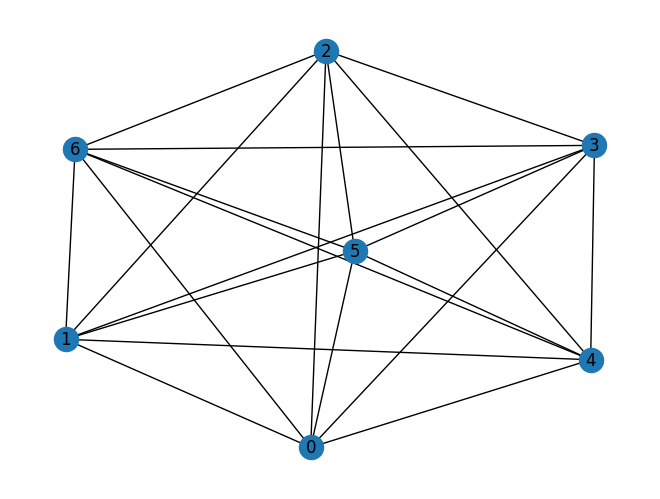

In [241]:
nx.draw(room_G, with_labels=True)
edgs = room_G.edges(data=True)

In [242]:
for e in edgs:
    print(e)

(0, 1, {'corridor_key': 0, 'crossed_corridors': [], 'crossed_rooms': []})
(0, 5, {'corridor_key': 1, 'crossed_corridors': [17, 19], 'crossed_rooms': []})
(0, 2, {'corridor_key': 7, 'crossed_corridors': [6, 9, 16, 18, 20], 'crossed_rooms': []})
(0, 3, {'corridor_key': 8, 'crossed_corridors': [19], 'crossed_rooms': []})
(0, 4, {'corridor_key': 16, 'crossed_corridors': [6, 7, 9, 18, 20], 'crossed_rooms': []})
(0, 6, {'corridor_key': 17, 'crossed_corridors': [1, 2, 13, 14, 18, 19], 'crossed_rooms': [5]})
(1, 5, {'corridor_key': 2, 'crossed_corridors': [18], 'crossed_rooms': []})
(1, 2, {'corridor_key': 6, 'crossed_corridors': [7, 9, 16, 18, 20], 'crossed_rooms': []})
(1, 3, {'corridor_key': 9, 'crossed_corridors': [6, 7, 16, 18, 20], 'crossed_rooms': []})
(1, 4, {'corridor_key': 10, 'crossed_corridors': [14], 'crossed_rooms': []})
(1, 6, {'corridor_key': 11, 'crossed_corridors': [14, 20], 'crossed_rooms': []})
(2, 3, {'corridor_key': 3, 'crossed_corridors': [12], 'crossed_rooms': []})
(2, 

In [243]:
groups_to_connect = [(0, 1), (1, 2)]
available_indices = set(range(num_rooms))
splits_it = iterate_G(available_indices, [3, 3, 3], 0, room_G)
found = False
for i, split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels) == 3:
            crossing_edges = get_crossing_edges_list(skels, room_G, groups_to_connect, paths_lst)
            found = True
            print(i, '::::', skels)
            break
    #if i>100:
    if found == True:
        break

In [244]:
% load_ext autoreload
% autoreload 2
from generateLayout import *

string = get_layout_str(walkable_points, skels, [], paths_lst, grid_size)
print(string)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
wwwwwwwwwwwwwwwwwwwwwwwwwwwwww
wwwwwwwwwww   w        wwwwwww
wwwwwwwwwww   w        wwwwwww
wwwwwwwwwww   w        wwwwwww
wwwwwwwwwww   w        wwwwwww
wwwwwwwwwww            w     w
wwwwwwwwwwwwwww        w     w
wwwwwwwwwwwwwww              w
wwwwwwwwwwwwwww        w     w
wwwwwwwwwwwwwwwwwwwwwwww     w
wwwwwwwwwwwwwwwwwwwwwwww     w
wwwwwwwwwwwwwwwwwwwwwwww     w
w         wwwwwwwwwwwwww     w
w         w   wwwwwwwwww     w
w         w   wwwwwwwwww     w
w         w   wwwwwwwwww     w
w         w   wwwwwwwwww     w
w         w   wwwwwwwwww     w
w         w   wwwwwwwwww     w
w             wwwwwwwwww     w
w         w   wwwwwwwwww     w
w         w   wwwwwwwwwwwwwwww
w         w   wwwwwwwwww     w
w         wwwwwwwwwwwwww     w
w         w   wwwwwwwwww     w
wwwwwwwwwww   wwwwwwwwwwwwww w
wwwwwwwwwww   w              w
wwwwwwwwwww   w wwwwwwwwwwwwww
wwwwwwwwwww     wwwwwwwwwwwwww
wwwwwwwwwwwww

In [245]:
ix = 2


def get_layout_str(walkable_points, skels, crossing_edges):
    edges = []
    for s in skels:
        edges += list(s['edges'])
    edges += crossing_edges
    walkable_points_all = list(walkable_points)
    for ix in edges:
        walkable_points_all += list(map(toL, paths_lst[ix][1]))
    walkable_points_all = set(walkable_points_all)
    string = create_string(walkable_points, grid_size)
    return string

In [246]:
get_points_from_group(2, skels, vertices_edges_dict_inv, room_G, paths_lst)

NameError: name 'vertices_edges_dict_inv' is not defined

In [ ]:

get_points_from_room(1, room_G)

In [ ]:
# skels is a list of skeletons for each group such as the one in the cell above
# [{'edges': {0, 12}, 'intersections': {15, 21, 24, 25, 28, 29}},
# {'edges': {5, 34}, 'intersections': {31, 35}},
# {'edges': {9, 10}, 'intersections': {14}}]
# groups is a tuple of indices (i,j) of the groups which should be connected..it uses the skels list indices
# [0,1]
# setA = get all vertices from group i (use get_vertices_from_edge_ids)
# setB = get all vertices from group j (use get_vertices_from_edge_ids)
# create all possible pairs (crossing edges) where the first element is from setA and the second from setB
# iterate over the crossing edges (refered here as e): (itertools)
# now when we speak about corridors we mean corridors which are present in the skeletons in the skel list
# these corridors are stored in the 'edges' key of a given skeleton
# if the crossing_edge e intersects some room or corridor from some other group than i or j then skip this edge (other groups are present in skels list)
# intA = get intersection between the crossing edge e and anything (either room or chosen corridor) in group i
# intB = same thing but for group j
# if both intA and intB are not empty then skip this crossing edge
# else return this edge

In [ ]:

print(crossing_edges)

In [ ]:

crossing_edges = get_crossing_edges(skels, groups_to_connect, vertices_edges_dict_inv, vertices_edges_dict)
get_edges_from_skels(crossing_edges, groups_to_connect, skels, vertices_edges_dict_inv, room_G, paths_lst,
                     vertices_edges_dict)

In [ ]:
paths_lst[4]